# ELO Scoring Function

In [204]:
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
import pickle
from parfor import parfor
import time

### Helper Functions

In [205]:
# Given eloA, and eloB, return the probability that A wins
def expected_prob(eloA, eloB):
    return 1 - (1 / (1+10**((eloA-eloB)/400)))

# Given eloA, eloB, constant = k, result of A. Return updated eloA, and eloB values
def update_elo(eloA, eloB, k, res):
    pa = expected_prob(eloA, eloB)
    eloA += (res - pa)*k
    eloB += ((1-res) - (1 - pa))*k
    return round(eloA,0), round(eloB,0)

def percentage(num):
    return round(num,4)*100

### Finding ELO on Datasets

In [206]:
# Example of ELO Calculation

eloA = 1200
eloB = 1000
pa = expected_prob(eloA, eloB)
print('Chance of A to win = ', percentage(pa), '%' )

res = 1 # A wins
eloA, eloB = update_elo(eloA, eloB, 100, res)
print('ELO of A = ', round(eloA, 0))
print('ELO of B = ', round(eloB, 0))

Chance of A to win =  75.97 %
ELO of A =  1224.0
ELO of B =  976.0


In [207]:
# See Bigger Dataframes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [208]:
# Input Tournament Data File
pklfile = "stacksim.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile

For the ELO List, to improve efficiency could add players and update ELO as you run through the matches. For now, it initializes a list of all the players and the code pulls from the list.

In [209]:
def init_elo_df(trn_data):
    elo_df = df({'Player': [], 'Group': [], 'ELO': []})
    start_elo = 1000
    for idx, trn in enumerate(trn_data):
        if idx % 3 == 0:
            for player1 in trn:
                elo_df.loc[len(elo_df.index)] = [player1, 1, start_elo]
            for player2 in trn[player1]:
                elo_df.loc[len(elo_df.index)] = [player2, 2, start_elo]
    return elo_df

# Read pkl data
# trn_data is a list w/ length of 4, and dicts inside w/ length of 12
# 1st level is 4 tournaments, 2nd level is 12 p1's, 3rd level is 12 p2's, 4th level is match histories
trn_data = pd.read_pickle(file_name)
elo_df = init_elo_df(trn_data)

In [210]:
# Output history dataframe (all data df) + ELO dataframe
hist_df = df({'Tournament': [], 'Player 1': [], 'Player 2': [], 'Result': [], 'Original ELO 1': [], 'New ELO 1': [], 'New ELO 2': []})
pvp_df = df({'Tournament': [], 'Player 1': [], 'Player 2': [], 'Wins': [], 'Games': []})
k = 100
trnnum = 0
for trn in trn_data:
    trnnum += 1
    print(trnnum)
    for player1 in trn:
        wins = 0
        draws = 0
        games = 0
        for player2 in trn[player1]:
            wins2 = 0
            games2 = 0
            history = trn[player1][player2]
            for match in history:
                eloA = elo_df.loc[(elo_df['Player'] == player1) & (elo_df['Group'] == 1), 'ELO'].iloc[0] # Get ELO A
                eloB = elo_df.loc[(elo_df['Player'] == player2) & (elo_df['Group'] == 2), 'ELO'].iloc[0] # Get ELO B
                res = 0
                ret1 = match[0]
                ret2 = match[1]
                games += 1
                games2 += 1
                if (ret1 > ret2):
                    wins += 1
                    wins2 += 1
                    res = 1
                elif (ret1 == ret2):
                    draws += 1
                    res = 0.5
                new_eloA, new_eloB = update_elo(eloA, eloB, k, res) 
                elo_df.loc[(elo_df['Player'] == player1) & (elo_df['Group'] == 1), 'ELO'] = new_eloA # Update ELO A
                elo_df.loc[(elo_df['Player'] == player2) & (elo_df['Group'] == 2), 'ELO'] = new_eloB # Update ELO B
                hist_df.loc[len(hist_df.index)] = [trnnum, player1, player2, res, eloA, new_eloA, new_eloB]
            pvp_df.loc[len(pvp_df.index)] = [trnnum, player1, player2, wins2, games2]


1
2
3
4


### Data Analysis

In [211]:
# Final ELO Rankings
player = 'SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt'
print(np.where(elo_df['Player'] == player)) # Group 1 and 2 treated as different players
elo_df.sort_values(by='ELO', ascending=False)

(array([ 8, 20], dtype=int64),)


,Player,Group,ELO
2,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,1908.0
1,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[32]_-checkpoint.pt,1.0,1899.0
0,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1838.0
3,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1827.0
5,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[64]_-checkpoint.pt,1.0,1745.0
6,"SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,1713.0
4,SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[32]_-checkpoint.pt,1.0,1693.0
7,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[32]_-checkpoint.pt,1.0,1677.0
10,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[32]_-checkpoint.pt,1.0,1584.0
8,SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[64]_-checkpoint.pt,1.0,1531.0


In [212]:
print(len(elo_df))
hist_df.head()

48


,Tournament,Player 1,Player 2,Result,Original ELO 1,New ELO 1,New ELO 2
0,1.0,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt","SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",0.0,1000.0,950.0,1050.0
1,1.0,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt","SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,950.0,1014.0,986.0
2,1.0,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt","SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",0.0,1014.0,960.0,1040.0
3,1.0,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt","SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",1.0,960.0,1021.0,979.0
4,1.0,"SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt","SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[128, 64, 32]_-checkpoint.pt",0.0,1021.0,965.0,1035.0


Best Player =  SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[64]_-checkpoint.pt
ELO =  1908.0


<AxesSubplot:xlabel='Player 1'>

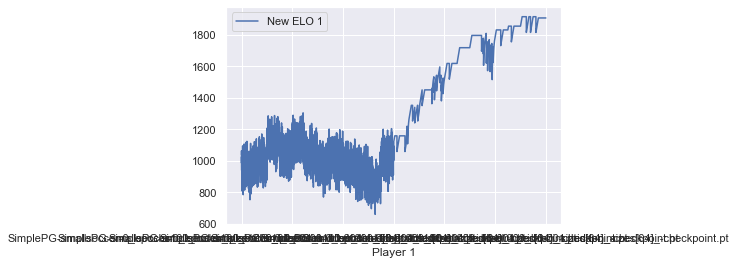

In [213]:
# Best Player
player = elo_df.sort_values(by='ELO', ascending=False).iat[0,0]
print("Best Player = ", player)
print("ELO = ", elo_df.sort_values(by='ELO', ascending=False).iat[0,2])
group = int(elo_df.sort_values(by='ELO', ascending=False).iat[0,1])
hist_df_players = hist_df.groupby('Player ' + str(group))
hist_df_player = hist_df_players.get_group(player)
hist_df_player.plot(x = 'Player ' + str(group), y = 'New ELO ' + str(group))


Worst Player =  StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[64]_-checkpoint.pt
ELO =  16.0


<AxesSubplot:xlabel='Player 2'>

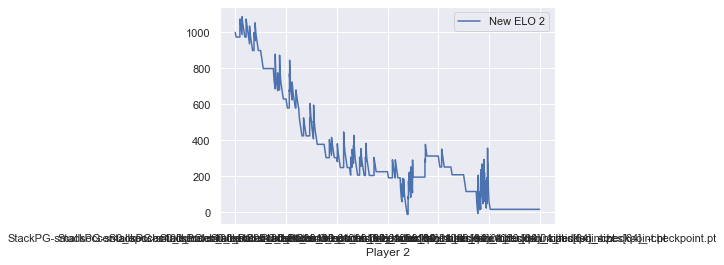

In [214]:
# Worst Player
player = elo_df.sort_values(by='ELO', ascending=False).iat[len(elo_df)-1,0]
print("Worst Player = ", player)
print("ELO = ", elo_df.sort_values(by='ELO', ascending=False).iat[len(elo_df)-1,2])
group = int(elo_df.sort_values(by='ELO', ascending=False).iat[len(elo_df)-1,1])
hist_df_players = hist_df.groupby('Player ' + str(group))
hist_df_player = hist_df_players.get_group(player)

hist_df_player.plot(x = 'Player ' + str(group), y = 'New ELO ' + str(group))

### Confusion Matrix


Test P1
SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[32]_-checkpoint.pt

Best P1
SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[64]_-checkpoint.pt

Test P1
SimplePG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[32]_-checkpoint.pt

Best P1
SimplePG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[64]_-checkpoint.pt

Worst P1
StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[32]_-checkpoint.pt

Best P1
StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[64]_-checkpoint.pt

Worst P1
StackPG-smallsoccer-0_epochs100_batch_size5000_lr0.001_hidden_sizes[32]_-checkpoint.pt


Test P1
StackPG-smallsoccer-0_epochs100_batch_size5000_lr0.01_hidden_sizes[64]_-checkpoint.pt


Worst P1
StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.001_hidden_sizes[32]_-checkpoint.pt

Best P1
StackPG-smallsoccer-0_epochs100_batch_size1000_lr0.01_hidden_sizes[64]_-checkpoint.pt

Worst P1
StackPG-smallsoccer-0_epoc

C:\Users\drago\anaconda3\lib\site-packages\ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


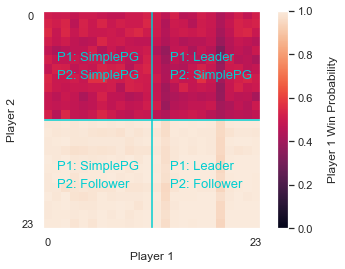

In [219]:
with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix = np.zeros((n,n))

count = 0
trncount = 0
for o in out:
    trncount += 1
    if (trncount > 2):
        count = 12
    else:
        count = 0
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            wins = pvp_df.loc[(pvp_df['Player 1'] == p1) & (pvp_df['Player 2'] == p2), 'Wins'].iloc[0]
            games = pvp_df.loc[(pvp_df['Player 1'] == p1) & (pvp_df['Player 2'] == p2), 'Games'].iloc[0]
            win_prob = wins / games
            game_matrix[idx1][idx2] = win_prob
        count += 1
print(count)

print(trncount)
sns.color_palette("light:#5A9", as_cmap=True)
plt.grid(False)
plt.imshow(game_matrix.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
cbr = plt.colorbar(cmap=sns.color_palette("light:#5A9", as_cmap=True))

cbr.set_label('Player 1 Win Probability',  labelpad=15)
plt.xticks([0,23])
plt.yticks([0,23])
colour = 'darkturquoise'
plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 13.5, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)

mean simp v simp: 0.49783333333333335
mean leader v simp: 0.4705555555555556
mean simp v follower: 0.9907916666666667
mean leader v follower: 0.989638888888889


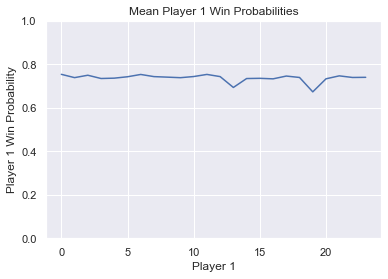

In [233]:
mean_matrix = np.mean(game_matrix, axis=1)
plt.plot(range(len(mean_matrix)), mean_matrix)

plt.ylim([0,1])
plt.ylabel("Player 1 Win Probability")
plt.xlabel("Player 1")
plt.title("Mean Player 1 Win Probabilities")
trans_game_matrix = game_matrix.transpose()
print('mean simp v simp:', np.mean(trans_game_matrix[0:12, 0:12]))
print('mean leader v simp:',np.mean(trans_game_matrix[0:12, 12:24]))
print('mean simp v follower:', np.mean(trans_game_matrix[12:24, 0:12]))
print('mean leader v follower:', np.mean(trans_game_matrix[12:24, 12:24]))

0


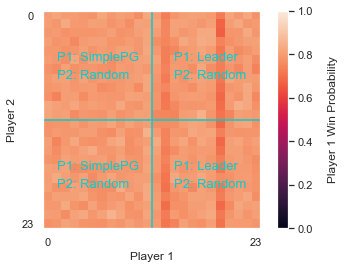

In [235]:
pklfile = "randAgent2_2.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile
with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix = np.zeros((n,n))

count = 0
trncount = 0
for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix[idx1][idx2] = win_prob

print(trncount)
sns.color_palette("light:#5A9", as_cmap=True)
plt.grid(False)
plt.imshow(game_matrix.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
cbr = plt.colorbar()

cbr.set_label('Player 1 Win Probability',  labelpad=15)
plt.xticks([0,23])
plt.yticks([0,23])
colour = 'darkturquoise'
plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 14, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)


In [237]:
trans_game_matrix = game_matrix.transpose()
print('mean simp v random:', np.mean(trans_game_matrix[0:12, 0:12]))
print('mean leader v random:',np.mean(trans_game_matrix[0:12, 12:24]))
print('mean simp v random:', np.mean(trans_game_matrix[12:24, 0:12]))
print('mean leader v random:', np.mean(trans_game_matrix[12:24, 12:24]))

mean simp v random: 0.794375
mean leader v random: 0.7831111111111111
mean simp v random: 0.7952361111111111
mean leader v random: 0.782638888888889


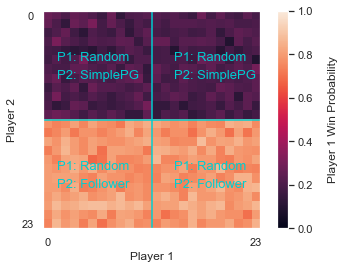

In [238]:
# Input Tournament Data File
pklfile = "randAgent1.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile

with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix2 = np.zeros((n,n))

for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix2[idx1][idx2] = win_prob
plt.grid(False)
plt.imshow(game_matrix2.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
colour = 'darkturquoise'
plt.xticks([0,23])
plt.yticks([0,23])

plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 14, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)
cbr = plt.colorbar()
cbr.set_label('Player 1 Win Probability',  labelpad=15)

In [239]:
trans_game_matrix = game_matrix2.transpose()
print('mean random v simp:', np.mean(trans_game_matrix[0:12, 0:12]))
print('mean random v simp:',np.mean(trans_game_matrix[0:12, 12:24]))
print('mean random v follower:', np.mean(trans_game_matrix[12:24, 0:12]))
print('mean random v follower:', np.mean(trans_game_matrix[12:24, 12:24]))

mean random v simp: 0.205
mean random v simp: 0.19951388888888888
mean random v follower: 0.7897222222222222
mean random v follower: 0.7915972222222222


Text(0.5, 1.0, 'Mean Player 1 Win Probabilities')

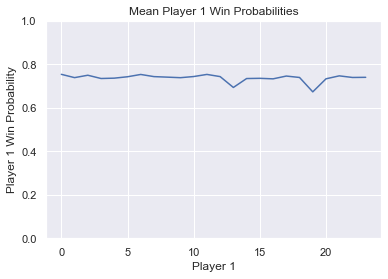

In [216]:
mean_matrix = np.mean(game_matrix, axis=1)
mean_matrix2 = np.mean(game_matrix2, axis=1)
plt.plot(range(len(mean_matrix2)), mean_matrix2)
plt.plot(range(len(mean_matrix)), mean_matrix)
# plt.axvline(x=13, color='k')
# plt.axvline(x=19, color='k')
# plt.axvline(x=11, color='r')
# plt.axvline(x=17, color='r')
plt.ylim([0,1])

plt.ylabel("Player 1 Win Probability")
plt.xlabel("Player 1")
plt.title("Mean Player 1 Win Probabilities")
plt.legend(['Random Player 1', 'Random Player 2'])

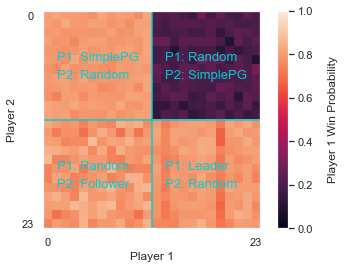

In [203]:
quad1 = game_matrix[0:12, 0:12]
quad2 = game_matrix2[12:24, 0:12]
quad3 = game_matrix2[12:24, 12:24]
quad4 = game_matrix[12:24, 0:12]
half1 = np.vstack((quad1, quad2))
half2 = np.vstack((quad3, quad4))
rand_game_matrix = np.hstack((half1, half2))
plt.grid(False)
plt.imshow(rand_game_matrix.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
colour = 'darkturquoise'
plt.xticks([0,23])
plt.yticks([0,23]) 
plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 13, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)

plt.text(textloc[2], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)

plt.text(textloc[0], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)

plt.text(textloc[2], textloc[3], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)

cbr = plt.colorbar()
cbr.set_label('Player 1 Win Probability',  labelpad=15)

Text(0.5, 1.0, 'Mean Player 1 Win Probabilities')

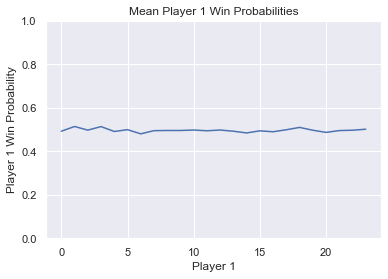

In [79]:
mean_matrix = np.mean(game_matrix, axis=1)
plt.plot(range(len(mean_matrix)), mean_matrix)
plt.ylim([0,1])
plt.ylabel("Player 1 Win Probability")
plt.xlabel("Player 1")
plt.title("Mean Player 1 Win Probabilities")

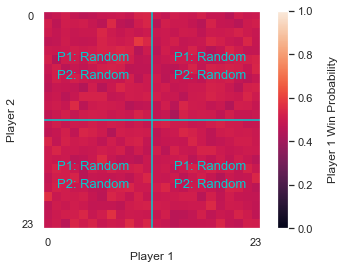

In [241]:
# Input Tournament Data File
pklfile = "randRand.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile

with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix3 = np.zeros((n,n))

for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix3[idx1][idx2] = win_prob
plt.grid(False)
plt.imshow(game_matrix3.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
colour = 'darkturquoise'
plt.xticks([0,23])
plt.yticks([0,23])

plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 14, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)
cbr = plt.colorbar()
cbr.set_label('Player 1 Win Probability',  labelpad=15)

mean random v random 0.49959374999999995


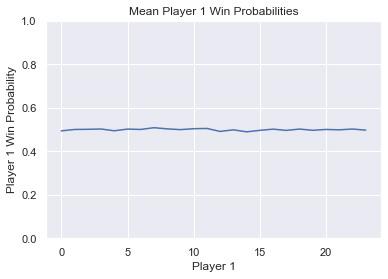

In [244]:
mean_matrix = np.mean(game_matrix3, axis=1)
plt.plot(range(len(mean_matrix)), mean_matrix)

plt.ylim([0,1])
plt.ylabel("Player 1 Win Probability")
plt.xlabel("Player 1")
plt.title("Mean Player 1 Win Probabilities")
trans_game_matrix = game_matrix3.transpose()
print('mean random v random', np.mean(trans_game_matrix))

## Gridhunter Cost Matrices

In [ ]:
pklfile = "gridStackSim.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile
with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix = np.zeros((n,n))


for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix[idx1][idx2] = win_prob

sns.color_palette()
plt.grid(False)
plt.imshow(game_matrix.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
cbr = plt.colorbar(cmap=sns.color_palette("light:#5A9", as_cmap=True))

cbr.set_label('Player 1 Win Probability',  labelpad=15)
plt.xticks([0,23])
plt.yticks([0,23])
colour = 'darkturquoise'
plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 13.5, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)

In [ ]:
mean_matrix = np.mean(game_matrix, axis=1)
plt.plot(range(len(mean_matrix)), mean_matrix)

plt.ylim([0,1])
plt.ylabel("Player 1 Win Probability")
plt.xlabel("Player 1")
plt.title("Mean Player 1 Win Probabilities")
trans_game_matrix = game_matrix.transpose()
print('mean simp v simp:', np.mean(trans_game_matrix[0:12, 0:12]))
print('mean leader v simp:',np.mean(trans_game_matrix[0:12, 12:24]))
print('mean simp v follower:', np.mean(trans_game_matrix[12:24, 0:12]))
print('mean leader v follower:', np.mean(trans_game_matrix[12:24, 12:24]))

In [ ]:
pklfile = "gridRandAgent2.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile
with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix = np.zeros((n,n))

for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix[idx1][idx2] = win_prob

sns.color_palette()
plt.grid(False)
plt.imshow(game_matrix.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
cbr = plt.colorbar()

cbr.set_label('Player 1 Win Probability',  labelpad=15)
plt.xticks([0,23])
plt.yticks([0,23])
colour = 'darkturquoise'
plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 14, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)

In [ ]:
trans_game_matrix = game_matrix.transpose()
print('mean simp v random:', np.mean(trans_game_matrix[0:12, 0:12]))
print('mean leader v random:',np.mean(trans_game_matrix[0:12, 12:24]))
print('mean simp v random:', np.mean(trans_game_matrix[12:24, 0:12]))
print('mean leader v random:', np.mean(trans_game_matrix[12:24, 12:24]))

In [ ]:
# Input Tournament Data File
pklfile = "gridRandAgent1.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile

with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix2 = np.zeros((n,n))

for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix2[idx1][idx2] = win_prob
plt.grid(False)
plt.imshow(game_matrix2.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
colour = 'darkturquoise'
plt.xticks([0,23])
plt.yticks([0,23])

plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 14, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)
cbr = plt.colorbar()
cbr.set_label('Player 1 Win Probability',  labelpad=15)

In [ ]:
trans_game_matrix = game_matrix2.transpose()
print('mean random v simp:', np.mean(trans_game_matrix[0:12, 0:12]))
print('mean random v simp:',np.mean(trans_game_matrix[0:12, 12:24]))
print('mean random v follower:', np.mean(trans_game_matrix[12:24, 0:12]))
print('mean random v follower:', np.mean(trans_game_matrix[12:24, 12:24]))

In [ ]:
quad1 = game_matrix[0:12, 0:12]
quad2 = game_matrix2[12:24, 0:12]
quad3 = game_matrix2[12:24, 12:24]
quad4 = game_matrix[12:24, 0:12]
half1 = np.vstack((quad1, quad2))
half2 = np.vstack((quad3, quad4))
rand_game_matrix = np.hstack((half1, half2))
plt.grid(False)
plt.imshow(rand_game_matrix.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
colour = 'darkturquoise'
plt.xticks([0,23])
plt.yticks([0,23]) 
plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 13, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: SimplePG', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)

plt.text(textloc[2], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: SimplePG', color=colour).set_size(textsize)

plt.text(textloc[0], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Follower', color=colour).set_size(textsize)

plt.text(textloc[2], textloc[3], 'P1: Leader', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)

cbr = plt.colorbar()
cbr.set_label('Player 1 Win Probability',  labelpad=15)

In [ ]:
# Input Tournament Data File
pklfile = "gridRandRand.pkl"
file_name = "C:/Users/drago/OneDrive - UW/Ratliff Research/tournaments/" + pklfile

with open(file_name,'rb') as f:
    out = pickle.load(f)
    
players = dict()

for o in out:
    for p in o.keys():
        if p not in players:
            players[p] = len(players)

n = len(players)
game_matrix3 = np.zeros((n,n))

for o in out:
    for p1 in o.keys():
        for p2 in o[p1].keys():
            idx1 = players[p1]
            idx2 = players[p2]
            
            rews = np.array(o[p1][p2])
            win_prob = (rews[:,0]>0).mean()
            game_matrix3[idx1][idx2] = win_prob
plt.grid(False)
plt.imshow(game_matrix3.transpose(), vmin=0, vmax=1)
plt.xlabel('Player 1')
plt.ylabel('Player 2')
colour = 'darkturquoise'
plt.xticks([0,23])
plt.yticks([0,23])

plt.axvline(x=11.5, color=colour)
plt.axhline(y=11.5, color=colour)
textloc = [1, 5, 14, 17]
textsize = 13
plt.text(textloc[0], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[1]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[0], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3], 'P1: Random', color=colour).set_size(textsize)
plt.text(textloc[2], textloc[3]+2, 'P2: Random', color=colour).set_size(textsize)
cbr = plt.colorbar()
cbr.set_label('Player 1 Win Probability',  labelpad=15)

In [ ]:
mean_matrix = np.mean(game_matrix3, axis=1)
plt.plot(range(len(mean_matrix)), mean_matrix)

plt.ylim([0,1])
plt.ylabel("Player 1 Win Probability")
plt.xlabel("Player 1")
plt.title("Mean Player 1 Win Probabilities")
trans_game_matrix = game_matrix3.transpose()
print('mean random v random', np.mean(trans_game_matrix))

In [256]:
test = np.empty_like([1,1], dtype=int)
print(len(test))
print(test)

2
[1 1]


In [258]:
test = np.zeros((4,9))
test[0][0] = 1
test[1][5+1] = 1
test[2][3+1] = 1
test[3][0] = 1
test.flatten()
print(test.flatten())

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
